# Julia Draw Something

In [1]:
using DataFrames
using TensorFlow
using Images

I tensorflow/stream_executor/dso_loader.cc:125] successfully opened CUDA library libcublas.so.8.0 locally
I tensorflow/stream_executor/dso_loader.cc:116] Couldn't open CUDA library libcudnn.so.5. LD_LIBRARY_PATH: /usr/local/cuda/lib64
I tensorflow/stream_executor/cuda/cuda_dnn.cc:3459] Unable to load cuDNN DSO
I tensorflow/stream_executor/dso_loader.cc:125] successfully opened CUDA library libcufft.so.8.0 locally
I tensorflow/stream_executor/dso_loader.cc:125] successfully opened CUDA library libcuda.so.1 locally
I tensorflow/stream_executor/dso_loader.cc:125] successfully opened CUDA library libcurand.so.8.0 locally
I tensorflow/stream_executor/dso_loader.cc:128] successfully opened CUDA library libcublas.so locally
I tensorflow/stream_executor/dso_loader.cc:128] successfully opened CUDA library libcudnn.so locally
I tensorflow/stream_executor/dso_loader.cc:128] successfully opened CUDA library libcufft.so locally
I tensorflow/stream_executor/dso_loader.cc:128] successfully opened CUD

In [2]:
data_set_folder = "/raided/datasets/sketches_png/png/"
list_of_imgs = open(data_set_folder * "filelist.txt")
img_paths = readlines(list_of_imgs)
close(list_of_imgs)

In [3]:
train_paths = Array(String, 700)
path_index = 1
count = 1
for i = 1:700
    train_paths[i] = img_paths[path_index]
    path_index += 1
    count += 1
    if count % 71 == 0
        count = 1
        path_index += 10
    end
end

test_paths = Array(String, 100)
path_index = 71
count = 1
for i = 1:100
    test_paths[i] = img_paths[path_index]
    path_index += 1
    count += 1
    if count % 11 == 0
        path_index += 70
        count = 1
    end
end

In [4]:
files_in_folder = readdir(data_set_folder)
labels = filter(x->isdir(data_set_folder * x) == true, files_in_folder)

250-element Array{String,1}:
 "airplane"     
 "alarm clock"  
 "angel"        
 "ant"          
 "apple"        
 "arm"          
 "armchair"     
 "ashtray"      
 "axe"          
 "backpack"     
 "banana"       
 "barn"         
 "baseball bat" 
 ⋮              
 "umbrella"     
 "van"          
 "vase"         
 "violin"       
 "walkie talkie"
 "wheel"        
 "wheelbarrow"  
 "windmill"     
 "wine-bottle"  
 "wineglass"    
 "wrist-watch"  
 "zebra"        

In [5]:
x = TensorFlow.placeholder(Float32)
y_ = TensorFlow.placeholder(Float32)
W = get_variable("weights", [77841, 10], Float32)
b = get_variable("bias", [10], Float32)

TensorFlow.Variable(<Operation 'bias'>,<Operation 'bias/Assign'>)

In [6]:
y = nn.softmax(x*W + b)
cross_entropy = reduce_mean(-reduce_sum(y_ .* log(y), reduction_indices=[2]))
train_step = train.minimize(train.GradientDescentOptimizer(.00001), cross_entropy)

W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.2 instructions, but these are available on your machine and could speed up CPU computations.
W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX instructions, but these are available on your machine and could speed up CPU computations.
W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX2 instructions, but these are available on your machine and could speed up CPU computations.
W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use FMA instructions, but these are available on your machine and could speed up CPU computations.


<Tensor NoOp:1 shape=unknown dtype=?>

In [7]:
type DataLoader
    cur_id::Int
    order::Vector{Int}
end

TrainLoader() = DataLoader(1, shuffle(1:700))
TestLoader() = DataLoader(1, shuffle(1:100))

TestLoader (generic function with 1 method)

In [8]:
test_image = load("/raided/datasets/sketches_png/png/airplane/1.png")
println(size(test_image))
something = reshape(test_image, 1234321)
black_pixels = filter(x-> x.val!=1, something)
white_pixels = filter(x-> x.val==1, something)
println(length(black_pixels))
println(length(white_pixels))

(1111,1111)
25781
1208540


(279,279)
6445
71396


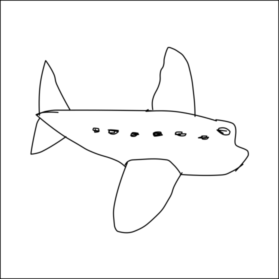

In [9]:
smaller_image = restrict(restrict(test_image))
println(size(smaller_image))
test_image = reshape(smaller_image, 77841)
black_pixels = filter(x-> x.val!=1, test_image)
white_pixels = filter(x-> x.val==1, test_image)
println(length(black_pixels))
println(length(white_pixels))
asdf = colorim(smaller_image)

(140,140)
2815
16785


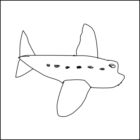

In [10]:
even_smaller_image = restrict(smaller_image)
println(size(even_smaller_image))
test = reshape(even_smaller_image, 19600)
black_pixels = filter(x-> x.val!=1, test)
white_pixels = filter(x-> x.val==1, test)
println(length(black_pixels))
println(length(white_pixels))
asdf = colorim(even_smaller_image)

In [11]:
function next_batch(loader::DataLoader, batch_size)
    x = zeros(Float32, batch_size, 77841)
    y = zeros(Float32, batch_size, 10)
    for i = 1:batch_size
        path = train_paths[loader.order[loader.cur_id]][1:end-1]
        sketch_name = split(path, "/")[1]
        img = load(data_set_folder * path)
        img = restrict(restrict(img))
        flatten_img = reshape(img, 77841)
        
        x[i, :] = flatten_img
        label = find((x -> x == sketch_name), labels)[1]
        y[i, label] = 1.0
        loader.cur_id += 1
        if loader.cur_id > 700
            break
        end
    end
    x, y
end

next_batch (generic function with 1 method)

In [12]:
function get_test(loader::DataLoader)
    x = zeros(Float32, 100, 77841)
    y = zeros(Float32, 100, 10)
    for i = 1:100
        path = test_paths[loader.order[loader.cur_id]][1:end-1]
        sketch_name = split(path, "/")[1]
        img = load(data_set_folder * path)
        img = restrict(restrict(img))
        flatten_img = reshape(img, 77841)
        
        x[i, :] = flatten_img
        label = find((x -> x == sketch_name), labels)[1]
        println("--------------------------")
        println(label)
        println(loader.cur_id)
        y[i, label] = 1.0
        loader.cur_id += 1
        if loader.cur_id > 100
            println("========================")
            println(sketch_name)
            break
        end
    end
    x, y
end

get_test (generic function with 1 method)

In [13]:
loader = TrainLoader()
saver = train.Saver()
gpu_options = TensorFlow.tensorflow.GPUOptions(allow_growth=true, per_process_gpu_memory_fraction=0.4)
config = TensorFlow.tensorflow.ConfigProto(gpu_options=gpu_options)
sess = Session(config=config)
run(sess, initialize_all_variables())
for i in 1:70
    batch = next_batch(loader, 10)
    run(sess, train_step, Dict(x=>batch[1], y_=>batch[2]))
    println("DONE BATCH ", i)
end

DONE BATCH 1
DONE BATCH 

I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:910] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
I tensorflow/core/common_runtime/gpu/gpu_device.cc:885] Found device 0 with properties: 
name: GeForce GTX 1070
major: 6 minor: 1 memoryClockRate (GHz) 1.683
pciBusID 0000:01:00.0
Total memory: 7.92GiB
Free memory: 7.00GiB
I tensorflow/core/common_runtime/gpu/gpu_device.cc:906] DMA: 0 
I tensorflow/core/common_runtime/gpu/gpu_device.cc:916] 0:   Y 
I tensorflow/core/common_runtime/gpu/gpu_device.cc:975] Creating TensorFlow device (/gpu:0) -> (device: 0, name: GeForce GTX 1070, pci bus id: 0000:01:00.0)


2
DONE BATCH 3
DONE BATCH 4
DONE BATCH 5
DONE BATCH 6
DONE BATCH 7
DONE BATCH 8
DONE BATCH 9
DONE BATCH 10
DONE BATCH 11
DONE BATCH 12
DONE BATCH 13
DONE BATCH 14
DONE BATCH 15
DONE BATCH 16
DONE BATCH 17
DONE BATCH 18
DONE BATCH 19
DONE BATCH 20
DONE BATCH 21
DONE BATCH 22
DONE BATCH 23
DONE BATCH 24
DONE BATCH 25
DONE BATCH 26
DONE BATCH 27
DONE BATCH 28
DONE BATCH 29
DONE BATCH 30
DONE BATCH 31
DONE BATCH 32
DONE BATCH 33
DONE BATCH 34
DONE BATCH 35
DONE BATCH 36
DONE BATCH 37
DONE BATCH 38
DONE BATCH 39
DONE BATCH 40
DONE BATCH 41
DONE BATCH 42
DONE BATCH 43
DONE BATCH 44
DONE BATCH 45
DONE BATCH 46
DONE BATCH 47
DONE BATCH 48
DONE BATCH 49
DONE BATCH 50
DONE BATCH 51
DONE BATCH 52
DONE BATCH 53
DONE BATCH 54
DONE BATCH 55
DONE BATCH 56
DONE BATCH 57
DONE BATCH 58
DONE BATCH 59
DONE BATCH 60
DONE BATCH 61
DONE BATCH 62
DONE BATCH 63
DONE BATCH 64
DONE BATCH 65
DONE BATCH 66
DONE BATCH 67
DONE BATCH 68
DONE BATCH 69
DONE BATCH 70


In [14]:
save_path = mktempdir()
println(save_path)
train.save(saver, sess, joinpath(save_path,"test"))

/tmp/tmpDyxDDI


In [15]:
correct_prediction = indmax(y, 2) .== indmax(y_, 2)
accuracy=reduce_mean(cast(correct_prediction, Float64))
test_loader = TestLoader()
testx, testy = get_test(test_loader)

--------------------------
9
1
--------------------------
6
2
--------------------------
3
3
--------------------------
3
4
--------------------------
10
5
--------------------------
6
6
--------------------------
1
7
--------------------------
9
8
--------------------------
8
9
--------------------------
4
10
--------------------------
1
11
--------------------------
9
12
--------------------------
8
13
--------------------------
4
14
--------------------------
4
15
--------------------------
1
16
--------------------------
7
17
--------------------------
1
18
--------------------------
5
19
--------------------------
8
20
--------------------------
10
21
--------------------------
6
22
--------------------------
9
23
--------------------------
2
24
--------------------------
8
25
--------------------------
7
26
--------------------------
5
27
--------------------------
9
28
--------------------------
2
29
--------------------------
8
30
--------------------------
9
31
---------------

(
Float32[0.165039 0.393555 … 0.393555 0.165039; 0.165039 0.393555 … 0.393555 0.165039; … ; 0.165039 0.393555 … 0.393555 0.165039; 0.165039 0.393555 … 0.393555 0.165039],

Float32[0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0])

In [16]:
println(run(sess, indmax(y, 2), Dict(x=>testx, y_=>testy)))
println(run(sess, indmax(y_, 2), Dict(x=>testx, y_=>testy)))
println("\n \n Accuracy: ", run(sess, accuracy, Dict(x=>testx, y_=>testy)))

[3,6,6,6,5,5,6,3,7,3,3,3,5,6,6,3,3,3,5,3,5,6,5,7,6,7,3,5,5,3,7,5,5,5,4,5,3,6,5,5,5,4,5,7,3,3,3,7,5,6,5,7,6,3,5,3,3,3,6,5,7,5,1,5,5,5,7,6,5,6,3,5,3,3,3,6,9,5,3,7,3,5,3,5,3,3,5,3,6,6,7,3,9,5,7,5,5,6,6,3]
[8,5,2,2,9,5,0,8,7,3,0,8,7,3,3,0,6,0,4,7,9,5,8,1,7,6,4,8,1,7,8,5,0,3,6,4,9,0,1,2,7,5,9,1,7,3,8,3,7,2,8,2,4,4,3,1,4,6,0,0,9,2,4,6,2,2,3,9,8,9,4,6,1,0,7,9,2,5,5,0,9,6,8,1,1,1,6,1,3,5,3,9,6,7,6,4,5,2,4,5]

 
 Accuracy: 0.07


In [17]:
function sketch_input(path, sketch_name)
    x = zeros(Float32, 1, 77841)
    y = zeros(Float32, 1, 10)
    img = load(path)
    img = restrict(restrict(img))
    flatten_img = reshape(img, 77841)
    x[1, :] = flatten_img
    
    label = find((x -> x == sketch_name), labels)[1]
    y[1, label] = 1.0
    
    x, y
end

sketch_input (generic function with 1 method)

In [18]:
sketch_path = "/raided/datasets/sketches_png/png/airplane/73.png"
sketch_label = "airplane"

test_img, test_label = sketch_input(sketch_path, sketch_label)
what_it_thinks = labels[run(sess, indmax(y,2), Dict(x=>test_img, y_=>test_label))[1] + 1]
println("Is it an " * what_it_thinks * "? Answer: ", (sketch_label == what_it_thinks), ".")

Is it an ant? Answer: false.
